# LangGraph 101

[LLMs](https://python.langchain.com/docs/concepts/chat_models/) make it possible to embed intelligence into a new class of applications. [LangGraph](https://langchain-ai.github.io/langgraph/) is a framework to help build applications with LLMs. Here, we will overview the basics of LangGraph, explain its benefits, show how to use it to build workflows / agents, and show how it works with [LangChain](https://www.langchain.com/) / [LangSmith](https://docs.smith.langchain.com/).

![ecosystem](./img/ecosystem.png)

## Chat models

[Chat models](https://python.langchain.com/docs/concepts/chat_models/) are the foundation of LLM applications. They are typically accessed through a chat interface that takes a list of [messages](https://python.langchain.com/docs/concepts/messages/) as input and returns a [message](https://python.langchain.com/docs/concepts/messages/) as output. LangChain provides [a standardized interface for chat models](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html), making it easy to [access many different providers](https://python.langchain.com/docs/integrations/chat/).

In [1]:
import os
from IPython.display import Image, display
from dotenv import load_dotenv
load_dotenv("../.env", override=True)

default_model = os.getenv("DEFAULT_MODEL")

In [2]:
import os
from langchain.chat_models import init_chat_model
llm = init_chat_model(default_model, temperature=0)

## Running the model

The `init_chat_model` interface provides [standardized](https://python.langchain.com/docs/concepts/runnables/) methods for using chat models, which include:
- `invoke()`: A single input is transformed into an output.
- `stream()`: Outputs are [streamed](https://python.langchain.com/docs/concepts/streaming/#stream-and-astream) as they are produced. 

In [3]:
result = llm.invoke("What is LangGraph?")

In [4]:
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
from rich.markdown import Markdown
Markdown(result.content)

LangGraph is an extension of the LangChain framework designed specifically for building stateful, multi-actor      
applications using a graph-based approach.                                                                         

In simpler terms, while LangChain helps you build sequences of operations (chains) and single-turn agents,         
LangGraph provides the tools to create much more sophisticated, dynamic, and interactive AI applications that can: 

 1 Maintain State: Remember information and context across multiple steps or "turns."                              
 2 Handle Complex Control Flow: Define conditional logic, loops, and branching paths in your application's         
   execution.                                                                                                      
 3 Orchestrate Multiple Agents or Components: Design systems where different AI agents, tools, or human            
   interventions can work together in a structured way.                                                            

                                         How it Works (The Core Concepts)                                          

LangGraph models your application as a state graph or a finite state machine. This graph consists of:              

 • State: This is the central piece of data that represents the current context of your application. It's typically
   a dictionary that gets passed from one node to the next and can be modified by them.                            
 • Nodes: These are the "steps" or "actors" in your graph. A node can be:                                          
    • An LLM call                                                                                                  
    • A tool invocation                                                                                            
    • A custom Python function                                                                                     
    • Another LangChain chain or agent                                                                             
    • A human in the loop Nodes take the current state as input, perform an action, and return an update to the    
      state.                                                                                                       
 • Edges: These define how the control flows between nodes.                                                        
    • Conditional Edges: The most powerful type. After a node executes, a "router function" determines which next  
      node to go to based on the node's output or the current state. This enables complex branching and            
      decision-making.                                                                                             
    • Unconditional Edges: Simply point from one node to another directly.                                         

                                                Why Use LangGraph?                                                 

LangGraph excels in scenarios where traditional LangChain chains or even basic LangChain agents fall short:        

 1 Autonomous Agents with Self-Correction and Loops: It's ideal for building agents that can plan, execute,        
   observe, and then re-plan or self-correct based on the outcome, forming iterative loops.                        
 2 Multi-Agent Systems: When you need to define how multiple AI agents interact, hand off tasks, or collaborate    
   (e.g., one agent for planning, another for tool execution, another for review).                                 
 3 Complex Conversational Flows: For chatbots that need deep memory, dynamic responses based on past turns, or     
   structured dialogues with multiple paths.                                                                       
 4 Human-in-the-Loop Workflows: Easily integrate points where a human user needs to review, approve, or provide    
   input before the AI process continues.       

## Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are utilities that can be called by a chat model. In LangChain, creating tools can be done using the `@tool` decorator, which transforms Python functions into callable tools. It will automatically infer the tool's name, description, and expected arguments from the function definition. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools. 

In [6]:
from langchain.tools import tool

@tool
def write_email(to: str, subject: str, content:str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject {subject} and content: {content}"

In [7]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [8]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [9]:
Markdown(write_email.description)

Write and send an email.

## Tool Calling

Tools can be [called](https://python.langchain.com/docs/concepts/tool_calling/) by LLMs. When a tool is bound to the model, the model can choose to call the tool by returning a structured output with tool arguments. We use the `bind_tools` method to augment an LLM with tools.

![tool-img](img/tool_call_detail.png)

Providers often have [parameters such as `tool_choice`](https://python.langchain.com/docs/how_to/tool_choice/) to enforce calling specific tools. `any` will select at least one of the tools.

In addition, we can [set `parallel_tool_calls=False`](https://python.langchain.com/docs/how_to/tool_calling_parallel/) to ensure the model will only call one tool at a time.

In [10]:
# Connect tools to a chat model
# model_with_tools = llm.bind_tools([write_email], tool_choice="any", parallel_tools_calls=False)  # This is the course version   
model_with_tools = llm.bind_tools([write_email], tool_choice="any")  # parallel_tools_calls doesn't work with Gemini model

# The model will now be able to call tools
output = model_with_tools.invoke("Draft a response to my boss about tomorrow's meeting")

In [11]:
type(output)

langchain_core.messages.ai.AIMessage

In [12]:
output

AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_email', 'arguments': '{"subject": "Tomorrow\'s Meeting", "to": "boss@example.com", "content": "Hi [Boss\'s name],\\n\\nI\'m writing to confirm my attendance at tomorrow\'s meeting. I look forward to discussing [meeting topic].\\n\\nThanks,\\n[Your Name]"}'}, '__gemini_function_call_thought_signatures__': {'7e9c6ff3-cac6-463d-bc29-6b3ed25e5291': 'CuIDAXLI2nxqQfNgIwFur6+NWRQH7GCbJhQJOGubKJgsf+PlnDBS22QuOjwW6pfnD1G3Gv3RZ3NEf2gN8T03KlXbPoCv2hDCkmp/J+tShK43jy533AAWS73aHLHPGvqoam5TkdjeeMPYrKBA3DloNhBcVD97jTUYcgz0OILo35VA/Zc+zh5SZYdA+rKJuI8eCwonoHQcWqEmndYTX4Rddf8shv8uuc9x8KYaQsZbIojsYFGymyzom0I55oSogyYgxbnjFOYvL4l8z85zB2OfAfM43GXjadjzIIEz8vVyQJmsDmYLnB6jUv6TP9USnvtP2prsHoavkmwRu1NmHLUD5Dh9q5D8rA4l3QAleOoasRpB68raL7bZnTQ+/dm/huCrhVN2Aa0OF9TRl8w7PVhoU5FIJgqPTwXpjfegXkiKl2dQz0x4wTNa2wtRSOqVD2WdKsFtNVIXT8TbskGeQarSMsY/GtROtyo9+GBPKz7rWFPkIUrDfdGdNlqky360t6qjQTxAsz4xz7pKntdirS/KzC9YQblnHvBckq0TICg4QqXTO4Vd25ruTYVe1IobPEEbsD

In [13]:
# Extract tool calls and execute them
args = output.tool_calls[0]['args']
args

{'subject': "Tomorrow's Meeting",
 'to': 'boss@example.com',
 'content': "Hi [Boss's name],\n\nI'm writing to confirm my attendance at tomorrow's meeting. I look forward to discussing [meeting topic].\n\nThanks,\n[Your Name]"}

In [14]:
# Call the tool
result = write_email.invoke(args)
print(result)  # "

Email sent to boss@example.com with subject Tomorrow's Meeting and content: Hi [Boss's name],

I'm writing to confirm my attendance at tomorrow's meeting. I look forward to discussing [meeting topic].

Thanks,
[Your Name]


![basic_prompt](img/tool_call.png)

## Workflows
 
There are many patterns for building applications with LLMs. 

[We can embed LLM calls into pre-defined workflows](https://langchain-ai.github.io/langgraph/tutorials/workflows/), giving the system more agency to make decisions. 

As an example, we could add a router step to determine whether to write an email or not.

![workflow_example](img/workflow_example.png)

## Agents

We can further increase agency, allowing the LLM to dynamically direct its own tool usage. 

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are typically implemented as tool calling in a loop, where the output of each tool call is used to inform the next action.

![agent_example](img/agent_example.png)

Agents are well suited to open-ended problems where it's difficult to predict the *exact* steps needed in advance.
 
Workflows are often appropriate when the control flow can easily be defined in advance. 

![workflow_v_agent](img/workflow_v_agent.png)

## What is LangGraph? 

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) provides low-level supporting infrastructure that sits underneath *any* workflow or agent. 

It does not abstract prompts or architecture, and provides a few benefits:

- **Control**: Make it easy to define and / or combine agents and workflows.
- **Persistence**: Provide a way to persist the state of a graph, which enables both memory and human-in-the-loop.
- **Testing, Debugging, and Deployment**: Provide an easy onramp for testing, debugging, and deploying applications.

### Control

LangGraph lets you define your application as a graph with:

1. *State*: What information do we need to track over the course of the application?
2. *Nodes*: How do we want to update this information over the course of the application?
3. *Edges*: How do we want to connect these nodes together?

We can use the [`StateGraph` class](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs) to initialize a LangGraph graph with a [`State` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

`State` defines the schema for information we want to track over the course of the application. 

This can be any object with `getattr()` in python, such as a dictionary, dataclass, or Pydantic object: 

- TypeDict is fastest but doesn’t support defaults
- Dataclass is basically as fast, supports dot syntax `state.foo`, and has defaults. 
- Pydantic is slower (especially with custom validators) but gives type validation.

In [15]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict):
    request: str
    email: str

workflow = StateGraph(StateSchema)

Each node is simply a python function or typescript code. This gives us full control over the logic inside each node.

They receive the current state, and return a dictionary to update the state.

By default, [state keys are overwritten](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/). 

However, you can [define custom update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). 

![nodes_edges](img/nodes_edges.png)

In [16]:
def write_email_node(state: StateSchema) -> StateSchema:
    # Imperative code that processes the request
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]['args']
    email = write_email.invoke(args)
    return {"email": email}

Edges connect nodes together. 

We specify the control flow by adding edges and nodes to our state graph. 

In [17]:
workflow = StateGraph(StateSchema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()

In [18]:
app.invoke({"request":"Draft a response to my boss about tomorrow's meeting"})

{'request': "Draft a response to my boss about tomorrow's meeting",
 'email': "Email sent to boss with subject Tomorrow's Meeting and content: Hi [Boss's name],\n\nI am writing to confirm my attendance at tomorrow's meeting. I look forward to discussing [meeting topic] with you all.\n\nBest regards,\n[Your name]"}

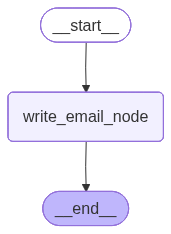

In [19]:
display(Image(app.get_graph().draw_mermaid_png()))

Routing between nodes can be done [conditionally](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) using a simple function. 

The return value of this function is used as the name of the node (or list of nodes) to send the state to next. 

You can optionally provide a dictionary that maps the `should_continue` output to the name of the next node.

In [20]:
from typing import Literal
from langgraph.graph import MessagesState
from email_assistant.utils import show_graph

def call_llm(state: MessagesState) -> MessagesState:
    """ Run LLM """

    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}


def run_tool(state: MessagesState):
    """ Performs the tool call """

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append({"role":"tool", "content": observation, "tool_call_id": tool_call["id"]})
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["run_tool", END]:
    """ Route to tool handler, or end if Done tool called """

    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]

    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls:
        return "run_tool"
    # Otherwise, we stop (reply to the user)
    return END


workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {"run_tool": "run_tool", END: END})
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

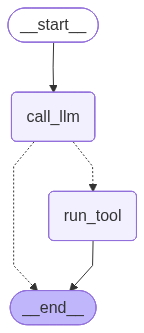

In [21]:
show_graph(app)

In [22]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (941720f2-abd6-4309-9972-68201f5d2012)
 Call ID: 941720f2-abd6-4309-9972-68201f5d2012
  Args:
    to: boss@company.ai
    content: This email is to confirm that I would like to attend Interrupt! I'm looking forward to it.
    subject: Confirming attendance at Interrupt!
================================= Tool Message =================================

Email sent to boss@company.ai with subject Confirming attendance at Interrupt! and content: This email is to confirm that I would like to attend Interrupt! I'm looking forward to it.


With these low level components, you can build many many different workflows and agents. See [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/)!

Because agents are such a common pattern, [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built) has [a pre-built agent](https://langchain-ai.github.io/langgraph/agents/overview/?ref=blog.langchain.dev#what-is-an-agent) abstraction.

With LangGraph's [pre-built method](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built), we just pass in the LLM, tools, and prompt. 

In [23]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided."
)

# Run the agent
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Draft a response to my boss confirming that I Want to attent Interrupt! boss@email.com"}]}
)

for m in result["messages"]:
    m.pretty_print()

/var/folders/6r/2xcy1mgx1db25_lz0x_wlr540000gn/T/ipykernel_856/1288270507.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


================================ Human Message =================================

Draft a response to my boss confirming that I Want to attent Interrupt! boss@email.com
================================== Ai Message ==================================
Tool Calls:
  write_email (ccade689-5400-4249-8509-99c2b1fbc515)
 Call ID: ccade689-5400-4249-8509-99c2b1fbc515
  Args:
    subject: Confirmation: Attending Interrupt!
    content: Hi [Boss's name],

This email is to confirm that I would like to attend Interrupt!.

Thanks,
[Your Name]
    to: boss@email.com
================================= Tool Message =================================
Name: write_email

Email sent to boss@email.com with subject Confirmation: Attending Interrupt! and content: Hi [Boss's name],

This email is to confirm that I would like to attend Interrupt!.

Thanks,
[Your Name]
================================== Ai Message ==================================

I have drafted and sent an email to your boss confirming your at

### Persistence

#### Threads

It can be very useful to allow agents to pause during long running tasks.

LangGraph has a built-in persistence layer, implemented through checkpointers, to enable this. 

When you compile graph with a checkpointer, the checkpointer saves a [checkpoint](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every step. 

Checkpoints are saved to a thread, which can be accessed after graph execution completes.

![checkpointer](img/checkpoints.png)

We compile the graph with a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).


In [24]:
from langgraph.checkpoint.memory import InMemorySaver

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided.",
    checkpointer=InMemorySaver()
)

config = {"configurable": {"thread_id":"1"}}
result = agent.invoke(
    {"messages": [{"role": "user", "content": "What area some good pratices for writing emails?"}]},
    config=config
)

/var/folders/6r/2xcy1mgx1db25_lz0x_wlr540000gn/T/ipykernel_856/2339333748.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


In [25]:
# Get the latest state snapshot
config = {"configurable": {"thread_id":"1"}}
state = agent.get_state(config)
for message in state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

What area some good pratices for writing emails?
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Here are some good practices for writing emails:\n\n*   **Clear Subject Line:** Make sure your subject line is concise and accurately reflects the email\'s content. This helps the recipient prioritize and understand the email\'s purpose at a glance.\n*   **Concise and Direct:** Get straight to the point. Most people appreciate emails that are easy to read and understand quickly.\n*   **Professional Tone:** Maintain a professional and respectful tone, even in informal exchanges.\n*   **Proper Grammar and Spelling:** Proofread your email before sending it to avoid typos and grammatical errors, which can detract from your message.\n*   **Structure and Formatting:** Use paragraphs, bullet points, or numbered lists to break up long blocks of text and impr

In [26]:
# Continue the conversation
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Good, let's use theese lessons to craft a response to my boss confirming that I want to attent Interrupt"}]},
    config=config
)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

What area some good pratices for writing emails?
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Here are some good practices for writing emails:\n\n*   **Clear Subject Line:** Make sure your subject line is concise and accurately reflects the email\'s content. This helps the recipient prioritize and understand the email\'s purpose at a glance.\n*   **Concise and Direct:** Get straight to the point. Most people appreciate emails that are easy to read and understand quickly.\n*   **Professional Tone:** Maintain a professional and respectful tone, even in informal exchanges.\n*   **Proper Grammar and Spelling:** Proofread your email before sending it to avoid typos and grammatical errors, which can detract from your message.\n*   **Structure and Formatting:** Use paragraphs, bullet points, or numbered lists to break up long blocks of text and impr

In [27]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "I like this, let's write the email to boss@company.ai"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What area some good pratices for writing emails?
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Here are some good practices for writing emails:\n\n*   **Clear Subject Line:** Make sure your subject line is concise and accurately reflects the email\'s content. This helps the recipient prioritize and understand the email\'s purpose at a glance.\n*   **Concise and Direct:** Get straight to the point. Most people appreciate emails that are easy to read and understand quickly.\n*   **Professional Tone:** Maintain a professional and respectful tone, even in informal exchanges.\n*   **Proper Grammar and Spelling:** Proofread your email before sending it to avoid typos and grammatical errors, which can detract from your message.\n*   **Structure and Formatting:** Use paragraphs, bullet points, or numbered lists to break up long blocks of text and impr

#### Interrupts

In LangGraph, we can also use [interrupts](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/) to stop graph execution at specific points.

Often this is used to collect input from a user and continue execution with collected input.

In [28]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

class State(TypedDict):
    input: str
    user_feedback: str

def step_1(state):
    print("---Step 1---")
    pass

def human_feedback(state):
    print("---Human Feedback---")
    feedback = interrupt("Please provide feedback")
    return {"user_feedback": feedback}

def step_3(state):
    print("---Step 3---")
    pass

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = InMemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

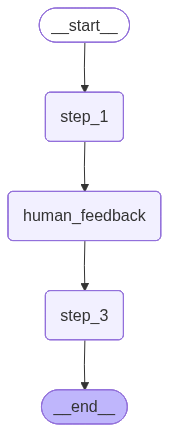

In [29]:
show_graph(graph)

In [30]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---Human Feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback', id='48994286177320e8c3ab1dcbd96ac919'),)}




To resume from an interrupt, we can use [the `Command` object](https://langchain-ai.github.io/langgraph/how-tos/command/). 

We'll use it to resume the graph from the interrupted state, passing the value to return from the interrupt call to `resume`. 

In [31]:
# Continue the graph exectuin
for event in graph.stream(
    Command(resume="go to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

---Human Feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




### Tracing

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```

Here is the LangSmith trace from above agent execution:

https://smith.langchain.com/public/6f77014f-d054-44ed-aa2c-8b06ceab689f/r

We can see that the agent is able to continue the conversation from the previous state because we used a checkpointer.

### Deployment

We can also deploy our graph using [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/). 

This creates a server [with an API](https://langchain-ai.github.io/langgraph/cloud/reference/api/api_ref.html) that we can use to interact with our graph and an interactive IDE, LangGraph [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/).

We simply need to ensure our project has [a structure](https://langchain-ai.github.io/langgraph/concepts/application_structure/) like this:

```
my-app/
├── src/email_assistant # all project code lies within here
│   └── langgraph101.py # code for constructing your graph
├── .env # environment variables
├── langgraph.json  # configuration file for LangGraph
└── pyproject.toml # dependencies for your project
```

The `langgraph.json` file specifies the dependencies, graphs, environment variables, and other settings required to start a LangGraph server.

To test this, let's deploy `langgraph_101.py`. We have it in our `langgraph.json` file in this repo:

```
 "langgraph101": "./src/email_assistant/langgraph_101.py:app",
```

For LangGraph Platform, there are a range of [deployment options](https://langchain-ai.github.io/langgraph/tutorials/deployment/): 
 
* Local deployments can be started with `langgraph dev` from the root directory of the repo. Checkpoints are saved to the local filesystem.
* There are also various [self-hosted options](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options). 
* For hosted deployments, checkpoints are saved to Postgres using a postgres [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). 

Test: 
```
Draft a response to my boss (boss@company.ai) confirming that I want to attent Interrupt!
```

Here we can see a visualization of the graph as well as the graph state in Studio.

![langgraph_studio](img/langgraph_studio.png)

Also, you can see API docs for the local deployment here:

http://127.0.0.1:2024/docs